# Implementation of a Quantum Linear Solver

## Motivation

<img src="images/DSC00764.JPG" width="50%" height="50%"/>

### Sources 

[1] D.Dervovic, M. Herbster, P. Mountney,S. Severini, N. Usher, L. Wossnig [*Quantum linear systems algorithms: a primer*](https://arxiv.org/abs/1802.08227)

[2] A. Harrow, A. Hassim, and S. Lloyd *Quantum algorithm for linear systems of equations*

[3] C. Bravo-Prieto, R. LaRose, M. Cerezo, Y. Subasi, L. Cincio, and P. Coles 
*Variational Quantum Linear Solver: A Hybrid Algorithm for linear systems*

[4] https://qiskit.org/textbook

## Outline

> Quantum Algorithms 

> Qiskit

> HHL

> VQLS 

# Quantum advantage

Reality of Quantum Computers

* NISQ

* Simulation 

## Quantum Algorithms 

* Leveraging quantum information


Gate Model with Unitary matrices


Most common gates

* Hadamard, CNot

* Pauli $X,Y,Z$

* Rotations $R_x, R_y R_z$


# Qiskit 

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute, circuit
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import noise

# HHL 
from qiskit.aqua import run_algorithm
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms.classical import ExactLSsolver

#Visualize
import matplotlib.pyplot as plt 
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_vector

import math
import random
import numpy as np
from scipy.optimize import minimize

qiskit.__qiskit_version__


{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.6',
 'qiskit-aqua': '0.6.4',
 'qiskit': '0.15.0'}

Four Elements Earth - Air - Water - Fire

* Compile

* OpenQasm 

* Backend 

Gateset

* $U_1, U_2, U_3$ and Cnot

Where 

$U_1(\lambda) = \begin{bmatrix}
        1 & 0 \\
        0 & e^{i\lambda} 
        \end{bmatrix} $

$U_2(\theta,\lambda) = \frac{1}{\sqrt{2}}\begin{bmatrix}
        1 & -e^{i\lambda} \\
        e^{i\theta} & e^{i(\lambda+\theta)} 
        \end{bmatrix} $
        
$U_3(\phi,\theta,\lambda) = \begin{bmatrix}
        cos(\frac{\theta}{2}) & -e^{i\lambda}sin(\frac{\theta}{2}) \\
        e^{i\theta}sin(\frac{\theta}{2}) & e^{i(\lambda+\theta)} 
        \end{bmatrix} $
        
      

Simulations

* Perfect 

* Noise 

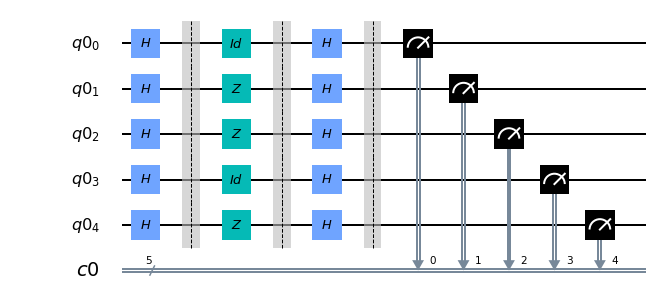

In [3]:
# Bernstein-Vazirani Algorithm
nQubits = 5  # number of qubits needed 
s = 22       # Secret number


qr = QuantumRegister(nQubits)
# Classical bits
cr = ClassicalRegister(nQubits)

bvCircuit = QuantumCircuit(qr, cr)
barriers = True

# Apply Hadamard gates 
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Apply barrier 
if barriers:
    bvCircuit.barrier()

# Oracle
for i in range(nQubits):
    if (s & (1 << i)):
        bvCircuit.z(qr[i])
    else:
        bvCircuit.iden(qr[i])
        
# Apply barrier 
if barriers:
    bvCircuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Apply barrier 
if barriers:
    bvCircuit.barrier()

# Measurement
bvCircuit.measure(qr, cr)
bvCircuit.draw(output='mpl')


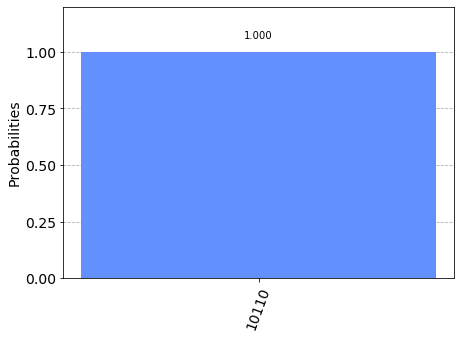

In [4]:
# use local simulator
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(bvCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

C:\Users\sigag\Anaconda3\envs\quantum\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


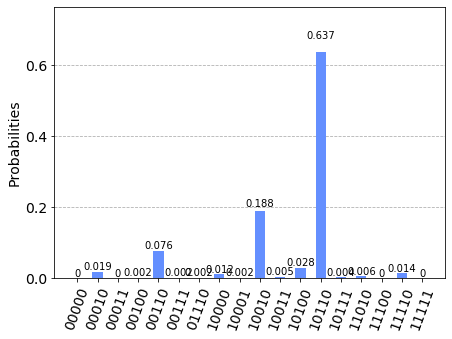

In [5]:
# Use noise 
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()

coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

noise_results= execute(bvCircuit, backend,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates).result()

noiseanswer = noise_results.get_counts(bvCircuit)


plot_histogram(noiseanswer)


# Quantum Linear Solver

Quantum Formulation of the linear solver

> Let A be an $N \times N$ Hermitian matrix with a unit determinant. Let b and x be N-dimentional vectors such that $x:=A^{-1}b$. Let the quantum state on $\lceil log(N)\rceil$ qubits |b> be given by $$ \frac{\sum_i b_i |i>}{|| \sum_i b_i |i> ||_2} $$ and for |x> by $$ \frac{\sum_i x_i |i>}{|| \sum_i x_i |i> ||_2} $$
where $b_i, x_i$ are the i-th components of b and x respectively. Given A and |b>, output a state $|\tilde{x}>$ such that $||(|\tilde{x}> - |x>) ||_2 \leq \epsilon $, with some probability larger than 1/2.


## HHL

<img src="images/HHLCircuit.png" width="80%" height="80%" />

### Hamiltonian Simulation

* Turning A into a Unitary operator $ e^{iAt} $

* ~$ O(log(N)s^2 t) $

### Phase Estimation
* Quantum Fourier transform

* Requires n extra control qubits

* Estimates the eigenvalues of A

### Rotation
* Ancilla qubit dependent on the eigenvalues

* Needs to be measured |1>  

### Uncompute

* Use the inverses to uncompute C and B 

* B now contains $|x>$

Improvements and variations




<img src="images/Evolution.png" width="50%" height="50%"/>

In [6]:
params = {
    'problem': {
        'name': 'linear_system'
    },
    'algorithm': {
        'name': 'HHL'
    },
    'eigs': {
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'name': 'EigsQPE',
        'num_ancillae': 3,
        'num_time_slices': 50
    },
    'reciprocal': {
        'name': 'Lookup'
    },
    'backend': {
        'provider': 'qiskit.BasicAer',
        'name': 'statevector_simulator'
    }
}

def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("fidelity %f" % fidelity)

In [7]:
matrix = [[1, 0], [0, 2]]
vector = [1, 4]
params['input'] = {
    'name': 'LinearSystemInput',
    'matrix': matrix,
    'vector': vector
}

In [8]:
hhl_output = run_algorithm(params)
print("solution ", np.round(hhl_output['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % hhl_output['probability_result'])
fidelity(hhl_output['solution'], result_ref['solution'])


C:\Users\sigag\Anaconda3\envs\quantum\lib\site-packages\qiskit\aqua\qiskit_aqua.py:119: DeprecationWarning: Declarative API will be removed next Aqua release. Please construct classes and call appropriate methods.
  warnings.warn(aqua_globals.CONFIG_DEPRECATION_MSG, DeprecationWarning)


solution  [1.05859-0.j 1.99245-0.j]
classical solution  [1. 2.]
probability 0.024630
fidelity 0.999389


In [9]:
params2 = params
params2['reciprocal'] = {
    'scale': 0.5
}

hhl_output2 = run_algorithm(params2)
print("solution ", np.round(hhl_output2['solution'], 5))

result_ref2 = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref2['solution'], 5))

print("probability %f" % hhl_output2['probability_result'])
fidelity(hhl_output2['solution'], result_ref['solution'])

print("circuit_width", hhl_output2['circuit_info']['width'])
print("circuit_depth", hhl_output2['circuit_info']['depth'])

C:\Users\sigag\Anaconda3\envs\quantum\lib\site-packages\qiskit\aqua\qiskit_aqua.py:119: DeprecationWarning: Declarative API will be removed next Aqua release. Please construct classes and call appropriate methods.
  warnings.warn(aqua_globals.CONFIG_DEPRECATION_MSG, DeprecationWarning)


solution  [0.84664+0.j 2.01762+0.j]
classical solution  [1. 2.]
probability 0.361437
fidelity 0.995605
circuit_width 7
circuit_depth 129


## Hybrid Algorithms 
* Both Quantum and Classical

* Desegined wiht NISQ in mind



### VQLS

<img src="images\VQLSCircuit.png" width="80%" height="80%" />


In [10]:
def apply_fixed_ansatz(qubits, parameters):
    for iz in range(0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range(0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range(0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])


In [11]:
def had_test(gate_type, qubits, ancilla_index, parameters):
    # Creates the Hadamard test
    circ.h(ancilla_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range(0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])

    for ie in range(0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])

    circ.h(ancilla_index)


In [12]:
def control_fixed_ansatz(qubits, parameters, ancilla, reg):

    for i in range(0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, ancilla),
                 qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(ancilla, qubits[1], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range(0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, ancilla),
                 qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(ancilla, qubits[2], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range(0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, ancilla),
                 qiskit.circuit.Qubit(reg, qubits[i]))


In [17]:
def control_b(ancilla, qubits):
    for ia in qubits:
        circ.ch(ancilla, ia)

In [14]:
def special_had_test(gate_type, qubits, ancilla_index, parameters, reg):

    circ.h(ancilla_index)

    control_fixed_ansatz(qubits, parameters, ancilla_index, reg)

    for ty in range(0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(ancilla_index, qubits[ty])

    control_b(ancilla_index, qubits)

    circ.h(ancilla_index)

In [15]:
def calculate_cost_function(parameters):
    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('statevector_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            job = execute(circ, backend)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('statevector_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                job = execute(circ, backend)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)


The problem is $$ A = \alpha_1 \mathbb{Z} + \alpha_2 \mathbb{I} $$ $$ b = \begin{bmatrix}
        \frac{1}{\sqrt{8}} \\
        \cdots \\
        \frac{1}{\sqrt{8}}
        \end{bmatrix}  $$ 

In [16]:
coefficient_set = [0.55, 0.45]
gate_set = [[0, 0, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])
a3 = np.add(a1, a2)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)


0.9889759175732641
0.9984515010031692
0.9941961555905245
0.7962256723668557
0.7683322520541489
0.7554331064406511
0.7440202216776846
0.5715702194434831
0.6217323263729735
0.591788596885295
0.5764212965342479
0.6066163602743924
0.4640735501687303
0.5014852564327783
0.45066834911979403
0.5608640795676592
0.5051130270442901
0.4955050569401631
0.49662206240177587
0.48116385372945636
0.4245320497812296
0.45324095755279303
0.5278716142128606
0.4561708227588923
0.39401171987738814
0.3695447900611939
0.3842709697808988
0.3737849176747825
0.3696828996388364
0.3822230530808529
0.3863180843188695
0.3799493780309503
0.3521844490392141
0.3575829357595032
0.35179963497753675
0.3695181143783566
0.3672546675197844
0.31239337518581245
0.322920713486611
0.31870263306673663
0.30276225280431623
0.29657771641567887
0.2527173834365227
0.1989617733132364
0.18140550653719179
0.3251723839924441
0.23156670946970248
0.3553589730833254
0.2112665623929041
0.2488083394205306
0.1816457780556724
0.22987901865814797
0

# My Thesis 

## Thesis questions

* What approaches are there to solve linear systems on Quantum computers

* Can you get near term supremacy with these approaches?

* Can you build on these implamentations?